In [62]:

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

numPerCountry = defaultdict( lambda : [0]*10 )

IN = open( "full_data.csv" , 'r' )

l = IN.readline() #header line
l = IN.readline() 

sep = ','

while l != "" :
    sl = l.strip().split(sep)

    country = sl[1]
    indexFirst = 0
    while not sl[2][indexFirst].isdigit():
        indexFirst += 1 # handle negative number of new cases
    new_cases_first_digit = int( sl[2][indexFirst] )
    if new_cases_first_digit != 0 :
        numPerCountry[ country ][ new_cases_first_digit ] += 1

    l = IN.readline()

IN.close()

OUT = open( 'new_case_first_digits.txt' , 'w' )

print(  'country total 1 2 3 4 5 6 7 8 9' , file=OUT)

worldTotal = [0]*10

for country in numPerCountry:
    print( country , sum(numPerCountry[country][1:]) , ' '.join([str(x) for x in numPerCountry[country][1:]]) , file=OUT )

    for i in range(1,10):
        worldTotal[i] += numPerCountry[country][i]

print( 'world' , sum(worldTotal[1:]) , ' '.join([str(x) for x in worldTotal[1:]]) , file = OUT )

OUT.close()


In [18]:
print( 'world' )



world
	n= 2474


In [99]:

def Benford_proba( digit ):
    """ returns the probability of a digit according to Benford's law """
    return np.log( 1+1/digit )/np.log(10)

def Benford_expected( n ):
    """ returns the vector of expected number of digit occurence according to Benford's law """
    return n * np.array( [ Benford_proba(x) for x in range(1,10) ] )

def Benford_CDF( digit ):
    """ returns the probability of a digit of lower digits according to Benford's law """    
    return sum( [ Benford_proba(x) for x in range(1,digit+1) ] )

def Benford_CDFvec( digit_vector ):
    """ computes the cdf of the a vector of values """
    values = {  }
    result = []
    for digit in digit_vector:
        if not digit in values :
            values[ digit ] = Benford_CDF( digit )
        result.append( values[digit] )
    return np.array(result)

def Benford_chi_square( digitCount ):
    """ takes a digit count as a list of observed
        occurence of the digits from 1 to 9
        and performs a chi_square test on it
    """
    
    exp = Benford_expected( sum(digitCount) )
    
    if not sum( exp>5 ) == 9 :
        print( "!warning : not all expected values are >= 5 \n\t the chi-square test is not valid." )
        
    return stats.chisquare( digitCount , exp )

def Benford_simulate( n ):
    ''' draws n values in the benfords law and create a digit count list from it '''
    vals = range( 1 ,  10 )
    probas = [ Benford_proba(x) for x in range(1,10) ]
    
    distrib = np.random.choice( vals , size = n , replace = True , p = probas )
    counts = [0]*10
    for x in distrib :
        counts[x] +=1
    return counts

def Benford_simulate_multiple( n , replicates ): 
    """ performs <replicates> of <n> draw in the Benfords law, 
        aggregates the counts of digits in lists.
    """

    aggregated = [  ]
    for i in range(10):
        aggregated.append( [] )
    
    i = 0
    while i < replicates:
        sample = Benford_simulate(n)
        for j in range(10):
            aggregated[j].append( sample[j] )
        i+=1
    return aggregated

def simulate_benford_enveloppe( n , replicates , q = [0.025,0.975] ):
    ''' returns lists corresponded to the observed quantiles for each digits 
        in <replicates> simulations of <n> draw in the Benfords law.
        '''
    aggregated_simulations = Benford_simulate_multiple( n , replicates )
    
    quantiles = []
    for x in q:
        quantiles.append([])
    
    for digitDistrib in aggregated_simulations :
        observedQ = np.quantile( digitDistrib , q )
        for i in range(len(q)):
            quantiles[i].append( observedQ[i] )
    return quantiles
    
        
    
def plotBenford( digitCount , title = "" ):
    
    exp = Benford_expected( sum(digitCount) )
    
    plt.plot( range(1,10) , digitCount  , color = 'orange' , linewidth = 2)
    plt.plot( range(1,10) , exp  , color = 'black' , linewidth = 2)
    plt.title(title)
    plt.xlabel('number first digit')
    plt.ylabel('number of occurence')
    plt.legend( [ 'observed' , 'expected' ] )
    
def plotEnveloppe( ax , q1 , q2 ):
    P1 = zip( range(1,10) , q1 )
    P2 = zip( range(1,10) , q2 )
    P1 = list(P1)
    P2 = list(P2)
    P2.reverse()
    ax.add_patch( Polygon( P1+P2 , color='grey' , alpha=0.5   ) )
    

In [53]:
print('world')
print( "\tn="      , sum(worldTotal[1:]) )
chisq,pval = Benford_chi_square( worldTotal[1:] )
print( '\tChi-sq',chisq , "\tp-value",pval )
KS,pval = stats.kstest( np.array(worldTotal[1:]) , Benford_CDFvec )
print( '\tKS',KS , "\tp-value",pval )

country = 'China'
print(country)
print( "\tn="      , sum(numPerCountry['China'][1:]) )
chisq,pval = Benford_chi_square( numPerCountry['China'][1:] )
print( '\tChi-sq',chisq , "\tp-value",pval )
KS,pval = stats.kstest( np.array(numPerCountry['China'][1:]) , Benford_CDFvec )
print( '\tKS',KS , "\tp-value",pval )


world
	n= 2474
	Chi-sq 110.90254255382943 	p-value 2.483717946007855e-20
	KS 2.085622803848432 	p-value 0.0
China
	n= 71
!warning : not all expected values are >= 5 
	 the chi-square test is not valid.
	Chi-sq 9.142444983880964 	p-value 0.33042243322845755
	KS 0.5444415169561408 	p-value 0.004998734234898359


The chi-square test is not applicable.
Even whan adding the [correction for discrete distribution](https://en.wikipedia.org/wiki/Benford%27s_law#Statistical_tests)
neither the world nor China data pass the Kolmogorov-Smirnov test.


In [100]:
N = 10000
simulatedQuantilesWorld = simulate_benford_enveloppe( n=sum(worldTotal[1:]) , replicates=N , q = [0.005,0.995,0.25,0.75] ) 

print('simulated',N,'replicates')
N = 10000
simulatedQuantilesChina = simulate_benford_enveloppe( n=sum(numPerCountry['China'][1:]) , replicates=N , q = [0.005,0.995,0.25,0.75] ) 

print('simulated',N,'replicates')

simulated 10000 replicates
simulated 10000 replicates


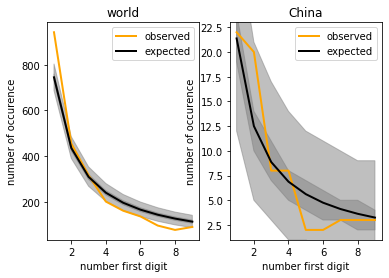

In [101]:

ax = plt.subplot(121)
plotBenford(worldTotal[1:] , 'world')
plotEnveloppe( ax , simulatedQuantilesWorld[0][1:] , simulatedQuantilesWorld[1][1:] )
plotEnveloppe( ax , simulatedQuantilesWorld[2][1:] , simulatedQuantilesWorld[3][1:] )


ax = plt.subplot(122)
plotBenford(numPerCountry['China'][1:], 'China')
plotEnveloppe( ax , simulatedQuantilesChina[0][1:] , simulatedQuantilesChina[1][1:] )
plotEnveloppe( ax , simulatedQuantilesChina[2][1:] , simulatedQuantilesChina[3][1:] )
plt.show()

simulated 10000 replicates


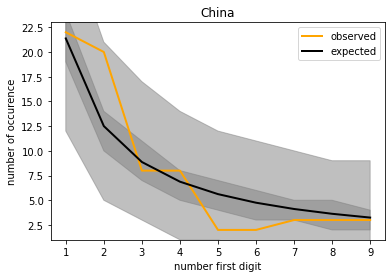

In [103]:


ax = plt.subplot(111)
plotBenford(numPerCountry['China'][1:], 'China')
plotEnveloppe( ax , simulatedQuantilesChina[0][1:] , simulatedQuantilesChina[1][1:] )
plotEnveloppe( ax , simulatedQuantilesChina[2][1:] , simulatedQuantilesChina[3][1:] )
plt.savefig('benford_coronoa_China_10000simul.svg')
